In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *

from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [17]:
pgroup='p20269'
runnumber = 168

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0168


'/sf/alvra/data/p20269/raw/run0168-PtStolS_timescan_2471p1_4uJ/meta/scan.json'

In [18]:
#fc = FileChooser('/sf/alvra/data/p20269/raw')
#fc.use_dir_icons = True
#display(fc)

In [19]:
#jsonfile = copy.copy(fc.selected)
#jsonfile

# Single scan, WITHOUT TT correction

In [20]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans_test/'

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

flag = False

Timezero_mm = 147.4889

try:
    flag = True
    Timezero_mm = get_timezero_NBS(jsonfile)
except:
    Timezero_mm = Timezero_mm
    
(DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
 DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, 
 Izero_pump, Izero_unpump, correlation1, correlation2, Delay_mm, Delay_fs, goodshots1, goodshots2) = \
XAS_delayscan_noTT_2diodes(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)
        
print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

if scan.parameters['units'] == ['nS']:
    Delay_fs = - scan.values
#    Delay_fs = Delay_fs - 0.17
else:
    Delay_fs = scan.values
    Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

run_name = jsonfile.split('/')[-3]
os.makedirs(reducedir+run_name, exist_ok=True)

save_data_timescans_2diodes(reducedir, run_name, Delay_mm, Delay_fs,
                            DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1,
                            DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, goodshots2)


Processing: run0168-PtStolS_timescan_2471p1_4uJ
Step 44 of 44: Processing acq0044

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY  993 / 1001 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 993 / 1001 -> 1% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 492 pump and 492 unpump shots
(116,) shots out of (492,) survived
(127,) shots out of (492,) survived
Step 44 of 44: Processed acq0044
correlation Diode1 (all shots) = 0.9922801203130832
correlation Diode2 (all shots) = 0.9907232087554668
------------------------------
Timezero found in file = 147.823420000045 mm


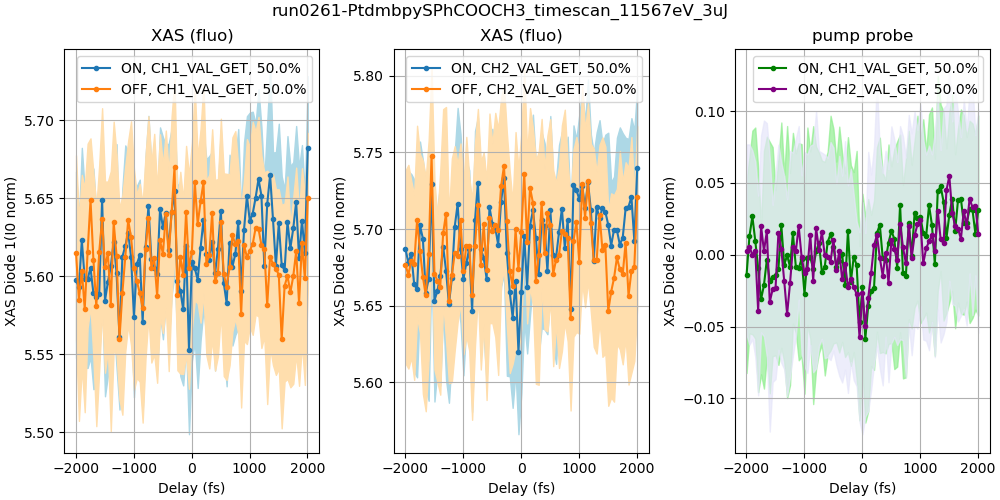

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3], fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS1_pump = DataDiode1_pump[:,0]
err1_low_pump = DataDiode1_pump[:,1]
err1_high_pump = DataDiode1_pump[:,2]
XAS1_unpump = DataDiode1_unpump[:,0]
err1_low_unpump = DataDiode1_unpump[:,1]
err1_high_unpump = DataDiode1_unpump[:,2]
XAS1_pump_probe = Pump_probe_Diode1[:,0]
err1_low_pump_probe = Pump_probe_Diode1[:,1]
err1_high_pump_probe = Pump_probe_Diode1[:,2]

XAS2_pump = DataDiode2_pump[:,0]
err2_low_pump = DataDiode2_pump[:,1]
err2_high_pump = DataDiode2_pump[:,2]
XAS2_unpump = DataDiode2_unpump[:,0]
err2_low_unpump = DataDiode2_unpump[:,1]
err2_high_unpump = DataDiode2_unpump[:,2]
XAS2_pump_probe = Pump_probe_Diode2[:,0]
err2_low_pump_probe = Pump_probe_Diode2[:,1]
err2_high_pump_probe = Pump_probe_Diode2[:,2]

ax1.plot(Delay_fs, XAS1_pump, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS1_unpump, label='OFF, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS2_pump, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Delay_fs, XAS2_unpump, label='OFF, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("XAS Diode 2(I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax3.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
ax3.fill_between(Delay_fs, err1_low_pump_probe, err1_high_pump_probe, alpha = 0.7, color='lightgreen')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))

ax3.plot(Delay_fs, XAS2_pump_probe, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),color='purple',marker='.')
ax3.fill_between(Delay_fs, err2_low_pump_probe, err2_high_pump_probe, alpha = 0.7, color='lavender')

ax3.set_xlabel("Delay (fs)")
ax3.set_ylabel ("XAS Diode 2(I0 norm)")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

# ax1.set_ylim(1.068, 1.10)
# ax2.set_ylim(0.985, 1.015)eV
# ax3.set_ylim(-0.005, 0.02)
# for ax in [ax1, ax2, ax3]:
#     ax.set_xlim(-3000, 10000)

plt.show()

#print(Delay_fs[0],Delay_fs[-1])

## Error Bars

In [14]:
#### CH1 ####
XAS1_pump      = DataDiode1_pump[:,0]
err1_low_pump  = (DataDiode1_pump[:,1]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)
err1_high_pump = (DataDiode1_pump[:,2]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)

XAS1_unpump      = DataDiode1_unpump[:,0]
err1_low_unpump  = (DataDiode1_unpump[:,1]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)
err1_high_unpump = (DataDiode1_unpump[:,2]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)

XAS1_pump_probe       = Pump_probe_Diode1[:,0]
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = DataDiode2_pump[:,0]
err2_low_pump    = (DataDiode2_pump[:,1]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)
err2_high_pump   = (DataDiode2_pump[:,2]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)

XAS2_unpump      = DataDiode2_unpump[:,0]
err2_low_unpump  = (DataDiode2_unpump[:,1]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)
err2_high_unpump = (DataDiode2_unpump[:,2]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)

XAS2_pump_probe       = Pump_probe_Diode2[:,0]
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

# Averaging 2 diodes

In [15]:
XAS_mean_pump = (XAS1_pump+XAS2_pump)/2
XAS_mean_unpump = (XAS1_unpump+XAS2_unpump)/2

offset1 = np.average(XAS1_unpump[0:5])
offset2 = np.average(XAS2_unpump[0:5])

ave_unpump = (XAS1_unpump-offset1 + XAS2_unpump-offset2)/2
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-offset1 + XAS2_pump-offset2)/2
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

##Average first, subtract later
ave_pp1 = ave_pump - ave_unpump
#ave_pp_err1 = np.sqrt((ave_unpump_err_h-ave_unpump_err_l)**2+np.square(ave_pump_err_h-ave_pump_err_l)**2)
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

##Average of the difference signals
factor = 1
ave_pp2 = (XAS1_pump_probe*factor + XAS2_pump_probe*factor)/2
ave_pp_err_l2 = ((err1_low_pump_probe + err2_low_pump_probe)/2)*factor
ave_pp_err_h2 = ((err1_high_pump_probe + err2_high_pump_probe)/2)*factor

# Plotting Averged Diodes with error bars

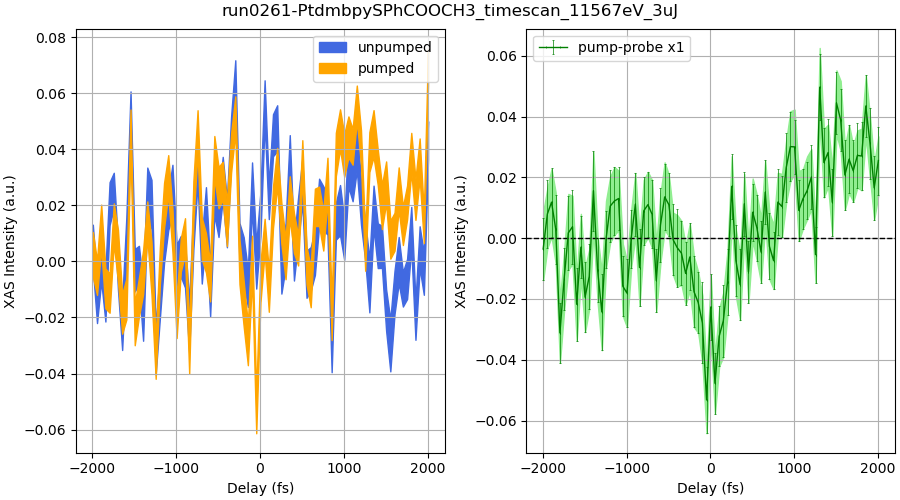

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3], fontsize = 12)


# ax1.axes.errorbar(Delay_fs,ave_unpump, ave_unpump_err_l ,ave_unpump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='unpumped')
# ax1.axes.errorbar(Delay_fs, ave_pump,  ave_pump_err_l,  ave_pump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='pumped')

#ax1.plot(Delay_fs,ave_unpump,lw=1,marker='o',markersize=3,label='unpumped')
ax1.fill_between(Delay_fs,ave_unpump-ave_unpump_err_l, ave_unpump+ave_unpump_err_h,color='royalblue',label='unpumped')
ax1.fill_between(Delay_fs,ave_pump-ave_pump_err_l, ave_pump+ave_pump_err_h,color='orange',label='pumped')

ax1.set_xlabel('Delay (fs)')
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.legend(loc='best')
#ax1.set_xlim(-400,900)

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Delay_fs, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pump-probe x{}'.format(factor))
#ax2.plot(Delay_fs,ave_pp1,lw=1,marker='o',markersize=3,color='green',label='unpumped')
ax2.fill_between(Delay_fs,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel('Delay (fs)')
ax2.set_ylabel('XAS Intensity (a.u.)')
ax2.grid()
ax2.legend(loc='best')
#ax2.set_xlim(-400,400)



## Check correlation for a certain delay point

In [131]:
chosen_delay_fs = 500

detector_XAS = channel_diode_2
detector_Izero = channel_Izero110

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(172,) shots out of (493,) survived
Correlation (all shots)      = 0.9747682655147969
Correlation (filtered shots) = 0.9965128449660507
Delay = 548.67 fs


In [132]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 9.425840820349482, Median (filtered) = 9.430252720182501
MAD (all) = 0.3746525413318077, MAD(filtered) = 0.2161073123914474
MAD/median (all) = 3.9747386835025793%, MAD/median (filtered) = 2.291638610372948%


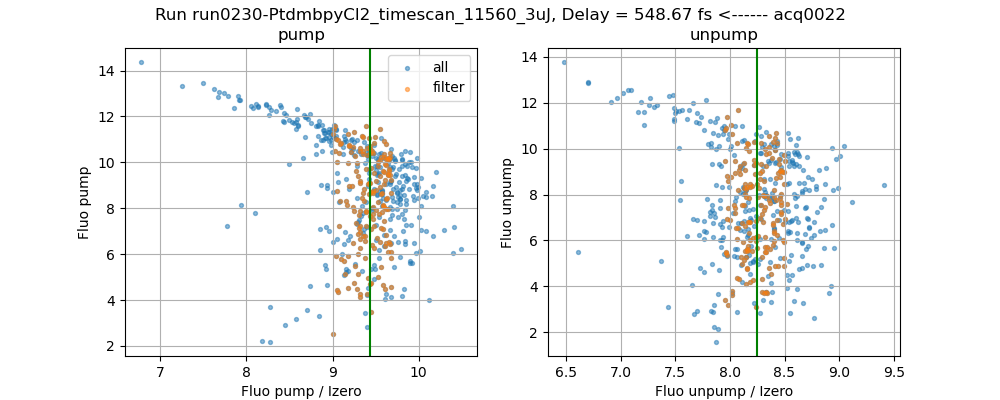

In [133]:
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)

plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.legend(loc='best')
plt.xlabel('Fluo pump / Izero')
plt.ylabel('Fluo pump')
plt.grid()

m_median_filter = np.median(Fluo_unpump_filter/Izero_unpump_filter)

plt.subplot(122)
plt.title('unpump')
plt.scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.xlabel('Fluo unpump / Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

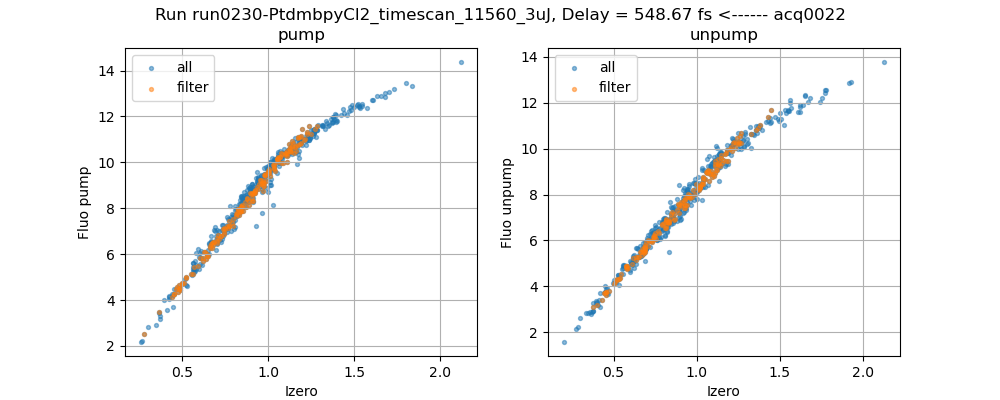

In [134]:
plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump, Fluo_pump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_pump_filter, Fluo_pump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump, Fluo_unpump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

# Loop of scans, WITHOUT TT correction

In [21]:
pgroup='p20269'
#runlist = [790]
runlist = np.arange(208, 211, 1)
#runlist = [179]
print ('{} runs: {}'.format(len(runlist),runlist))

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
jsonlist

3 runs: [208 209 210]


['/sf/alvra/data/p20269/raw/run0208-NAPPtCl_timescan_11560eV_3uJ_001/meta/scan.json',
 '/sf/alvra/data/p20269/raw/run0209-NAPPtCl_timescan_11560eV_3uJ_002/meta/scan.json',
 '/sf/alvra/data/p20269/raw/run0210-NAPPtCl_timescan_11560eV_3uJ_003/meta/scan.json']

In [22]:
quantile_corr = 0.6
Timezero_mm = 147.48892    ## this in mm from the YAG scans

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans/'

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode1_pump_all = []
DataDiode1_unpump_all = []
Pump_probe1_all = []

DataDiode2_pump_all = []
DataDiode2_unpump_all = []
Pump_probe2_all = []

Delay_fs_all = []

for json_file in jsonlist:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    flag = False
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    DataDiode1_pump = []
    DataDiode1_unpump = []
    Pump_probe_Diode1 = []
    
    DataDiode2_pump = []
    DataDiode2_unpump = []
    Pump_probe_Diode2 = []
    
    (DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
     DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, _, _, _, _, 
     Delay_mm, Delay_fs, goodshots1, goodshots2) = XAS_delayscan_noTT_2diodes(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)
    
    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))
        
    if scan.parameters['units'] == ['nS']:
        Delay_fs = - scan.values
    #    Delay_fs = Delay_fs - 0.17
    else:
        Delay_fs = scan.values
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
    DataDiode1_pump_all.append(DataDiode1_pump)
    DataDiode1_unpump_all.append(DataDiode1_unpump)
    Pump_probe1_all.append(Pump_probe_Diode1)    
    
    DataDiode2_pump_all.append(DataDiode2_pump)
    DataDiode2_unpump_all.append(DataDiode2_unpump)
    Pump_probe2_all.append(Pump_probe_Diode2) 
    
    Delay_fs_all.append(Delay_fs)
    
    run_name = json_file.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)
    
    save_data_timescans_2diodes(reducedir, run_name, Delay_mm, Delay_fs,
                                DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1,
                                DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, goodshots2)
    
    print ('Processed run {}'.format(json_file.split('/')[-3]))

DataDiode1_pump_all = np.array(DataDiode1_pump_all)
DataDiode1_unpump_all = np.array(DataDiode1_unpump_all)
Pump_probe1_all = np.array(Pump_probe1_all)
DataDiode2_pump_all = np.array(DataDiode2_pump_all)
DataDiode2_unpump_all = np.array(DataDiode2_unpump_all)
Pump_probe2_all = np.array(Pump_probe2_all)
Delay_fs_all = np.array(Delay_fs_all)


Processing: run0210-NAPPtCl_timescan_11560eV_3uJ_003
Step 65 of 65: Processing acq0065

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY  999 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 1001 -> 0% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 498 pump and 498 unpump shots
(176,) shots out of (498,) survived
(177,) shots out of (498,) survived
Step 65 of 65: Processed acq0065
correlation Diode1 (all shots) = 0.989612362934895
correlation Diode2 (all shots) = 0.992212841253984
------------------------------
Timezero found in file = 162.427820000045 mm
Processe

In [68]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

NameError: name 'goodshots1_all' is not defined

NameError: name 'DataDiode_pump_all' is not defined

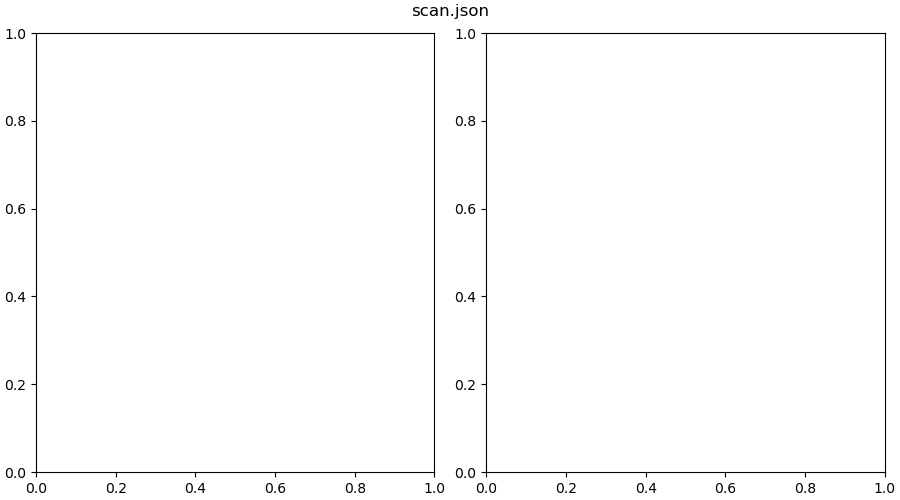

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = (XAS_pump - np.mean(DataDiode_pump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_pump = (np.mean(DataDiode_pump_all, axis=0)[:,2]-XAS_pump)/np.sqrt(len(patch))
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = (XAS_unpump - np.mean(DataDiode_unpump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_unpump = (np.mean(DataDiode_unpump_all, axis =0)[:,2]-XAS_unpump)/np.sqrt(len(patch))
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]#/np.sqrt(len(patch))
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]#/np.sqrt(len(patch))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

In [70]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2), axis=0)
err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2), axis=0)

XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2), axis=0)
err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2), axis=0)

XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

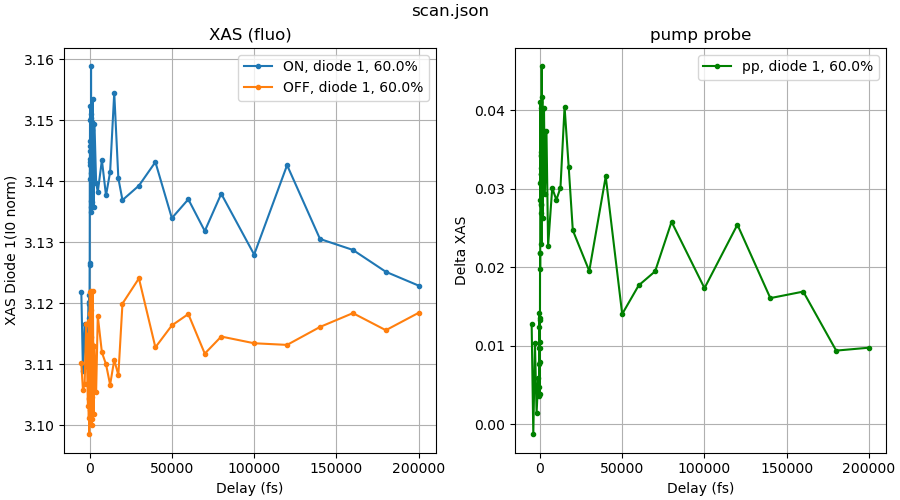

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode1_pump_all, axis=0)[:,0]

XAS_unpump = np.mean(DataDiode1_unpump_all, axis=0)[:,0]

XAS_pump_probe = np.mean(Pump_probe1_all, axis=0)[:,0]

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
#ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
#ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()


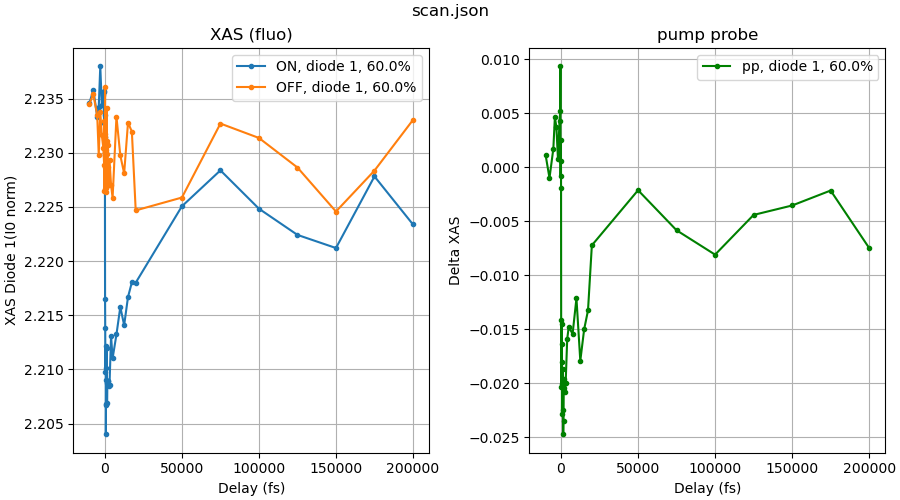

In [256]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode2_pump_all, axis=0)[:,0]

XAS_unpump = np.mean(DataDiode2_unpump_all, axis=0)[:,0]

XAS_pump_probe = np.mean(Pump_probe2_all, axis=0)[:,0]

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
#ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
#ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()
